## 一、算法介绍

随机森林属于集成学习（Ensemble Learning）中的一种，它是通过构建多个决策树，并综合这些决策树的预测结果来进行最终的预测。就好比一群经验丰富的专家（各个决策树）共同商讨一件事，然后汇总大家的意见（预测结果）得出最终结论，往往这样综合考量后的结果会更加准确可靠。

随机森林可以用于解决分类问题，比如判断一封邮件是垃圾邮件还是正常邮件；也能处理回归问题，例如预测某地区的房价走势等。它具有以下优点：

- **准确性高**：通过集成多个决策树，减少了单个模型的偏差和方差，通常能获得比单一决策树更好的预测性能。
- **鲁棒性强**：对数据中的噪声和异常值有较好的容忍度，不太容易因为个别“捣乱”的数据而导致整体预测结果偏差过大。
- **可处理高维数据**：在面对具有众多特征的数据时，依然能够较好地发挥作用，筛选出重要特征并进行有效预测。

## 二、算法原理

### 1. **决策树基础**

随机森林的基本组成单元是决策树。决策树是一种基于树结构进行决策的模型，它通过对数据集特征的不断划分来构建树形结构。

例如，我们有一个简单的数据集，特征包括天气（晴天、多云、下雨）、温度（高、中、低），要预测是否适合外出活动。决策树可能会先根据天气特征进行划分，如果是晴天，再看温度情况等，逐步构建出一个类似树状的决策流程，最终每个叶子节点对应一个预测结果（适合外出或者不适合外出）。

对于分类决策树，其构建过程通常采用信息增益（$I G$）、信息增益比或者基尼指数（$Gini$）等指标来选择最优的特征进行划分，公式如下：

**信息增益（以熵来衡量信息不确定性）**：

$$I G(D, A)=E(D)-E(D \mid A)$$

其中，$D$表示整个数据集，$A$是要划分的特征，$E(D)$表示数据集 $D$ 的熵，$E(D \mid A)$ 表示在特征 $A$ 划分后的条件熵。

**基尼指数**：

$$Gini(D)=1-\sum_{k=1}^{|K|} p_{k}^{2}$$

这里 $K$ 表示类别集合，$p_{k}$ 表示数据集中属于第 $k$ 类的概率。

### 2. **随机森林的构建**

随机森林在构建决策树时有两个关键的随机化步骤：

- **样本随机采样**：从原始训练数据集中有放回地随机抽取一定数量的样本，构成每个决策树的训练数据集。这样做可以使得每棵树的训练样本略有不同，增加了模型的多样性。假设原始数据集大小为 $n$，一般每次采样也是 $n$ 个样本（有放回采样会存在重复样本情况），通过这种自助采样法（Bootstrap Sampling），大约有 $1 - \frac{1}{e} \approx 63.2\%$ 的原始样本会出现在采样数据集中，剩下的约 $36.8\%$ 的样本被称为袋外数据（Out-of-Bag，OOB），这些 OOB 数据可以用于后续的模型评估等操作。

- **特征随机选择**：在构建每棵决策树时，在节点进行划分时，并不是从所有特征中选择最优特征来划分，而是从全部特征中随机挑选出一部分特征（例如，假设有 $m$ 个特征，每次随机选 $\sqrt{m}$ 个特征），然后在这部分特征里找出最佳的划分特征。这进一步增加了决策树之间的差异性。

当构建好众多的决策树（假设构建了 $T$ 棵决策树）后，对于分类问题，随机森林的预测结果通常采用投票法，即统计每棵树预测的类别，选择出现次数最多的类别作为最终预测类别；对于回归问题，则是将每棵树的预测值进行平均，得到最终的预测值。

## 三、案例分析——基于随机森林的机器故障预测

### 1. **数据集介绍**
   - 该数据集包含了机器运行的相关信息，共有8998条记录，10个字段。其中主要字段包括：
     - **机器编号**：用于唯一标识每台机器。
     - **统一规范代码**：可能与机器的类型或规格相关。
     - **机器质量等级**：反映机器的质量层次，可能影响其运行稳定性和故障概率。
     - **工厂温度**：机器运行环境的温度情况。
     - **机器温度**：机器自身运行时的温度。
     - **转速（rpm）**：机器运行的转速。
     - **扭矩（Nm）**：机器工作时产生的扭矩。
     - **使用时长（min）**：机器已经运行的累计时长。
     - **是否发生故障**：目标变量，表示机器是否出现故障，1表示发生故障，0表示未发生故障。
     - **具体故障类别**：进一步细分故障的类型。

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2624
           1       0.88      0.58      0.70        76

    accuracy                           0.99      2700
   macro avg       0.93      0.79      0.85      2700
weighted avg       0.98      0.99      0.98      2700



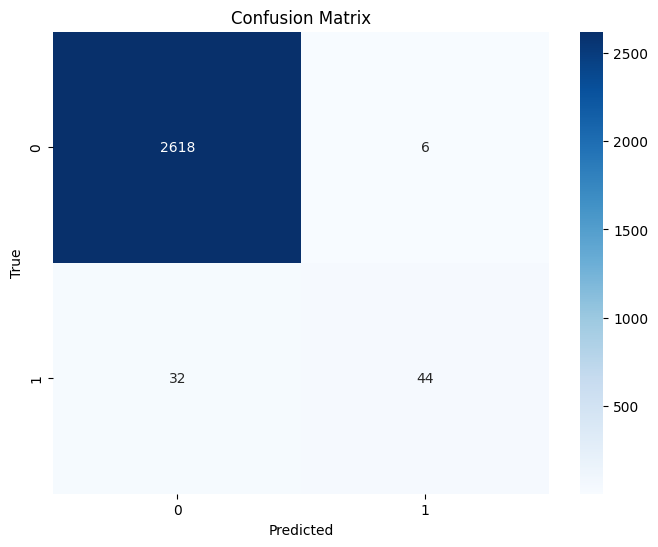

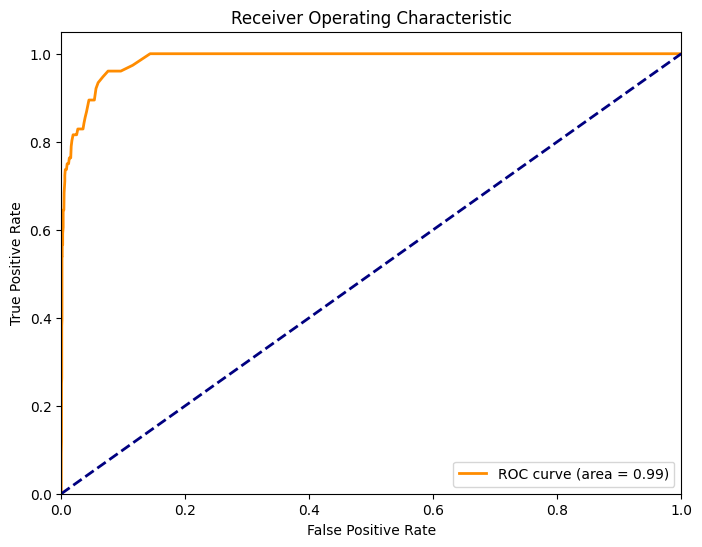

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

# 定义excel文件路径
file_path = 'data.xlsx'

# 加载数据
data = pd.read_excel(file_path)

# 定义特征列名列表
feature_cols = ['机器质量等级', '工厂温度', '机器温度', '转速（rpm）', '扭矩（Nm）', '使用时长（min）']

# 选取特征列作为特征变量X
X = data.loc[:, feature_cols]

# 选取目标列作为目标变量y
y = data['是否发生故障']

# 划分训练集和测试集，测试集大小为30%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 创建随机森林分类器，设置决策树数量为100
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# 使用训练集训练模型
rf.fit(X_train, y_train)

# 使用训练好的模型对测试集进行预测
y_pred = rf.predict(X_test)

# 输出分类报告
print(classification_report(y_test, y_pred))

# 计算混淆矩阵
cm = confusion_matrix(y_test, y_pred)

# 绘制混淆矩阵热力图
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# 计算ROC曲线相关数据
y_pred_proba = rf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# 绘制ROC曲线
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()